In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import QuantileTransformer

df = pd.read_csv("LABS-interpolated.csv") 

# Create the "Timestamp" column
df['Timestamp'] = pd.to_datetime(df['time_column'], format='%Y-%m-%d')
df = df.drop(['Year', 'Month', 'Day','time_column'], axis=1)
print(df['Timestamp'][0])

df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

2020-01-01 00:00:00


array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>],
      dtype=object)

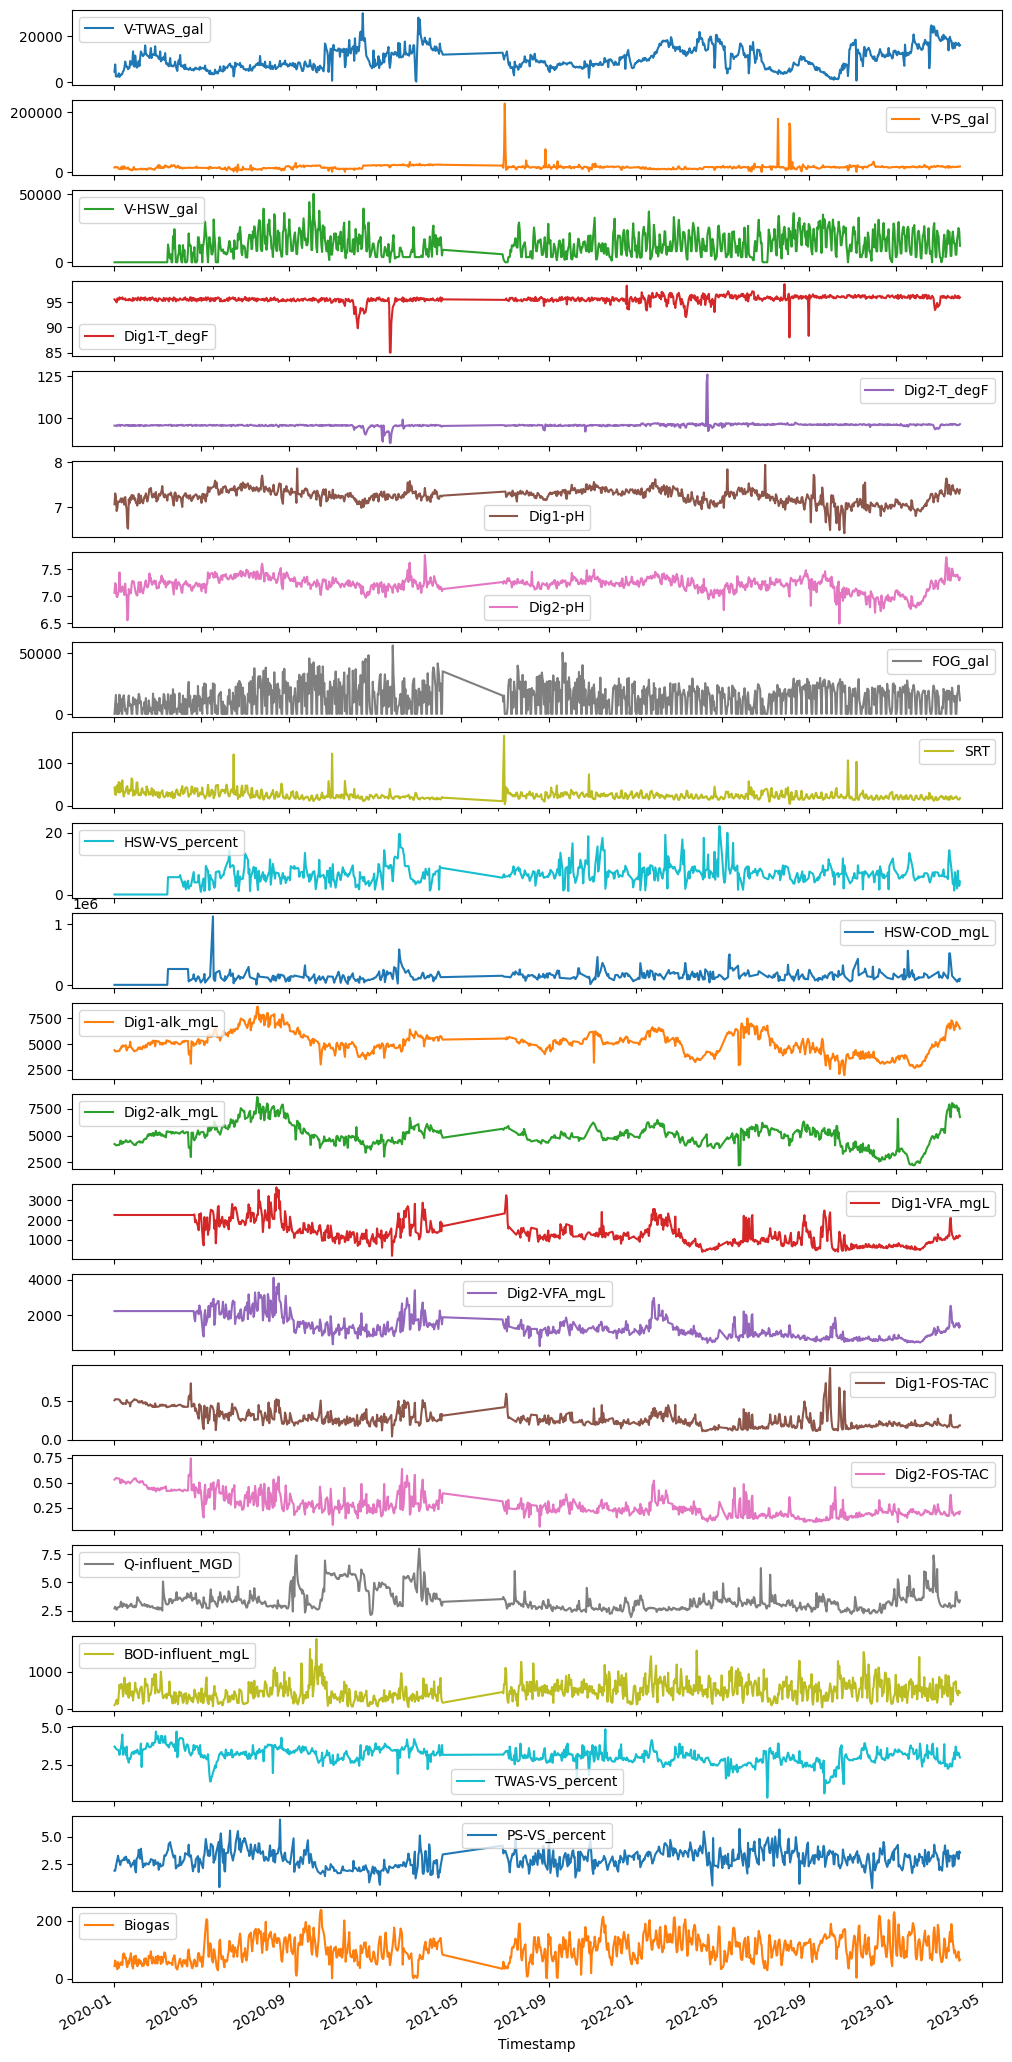

In [2]:
df.plot(subplots=True, figsize=(12, 29))

<Axes: >

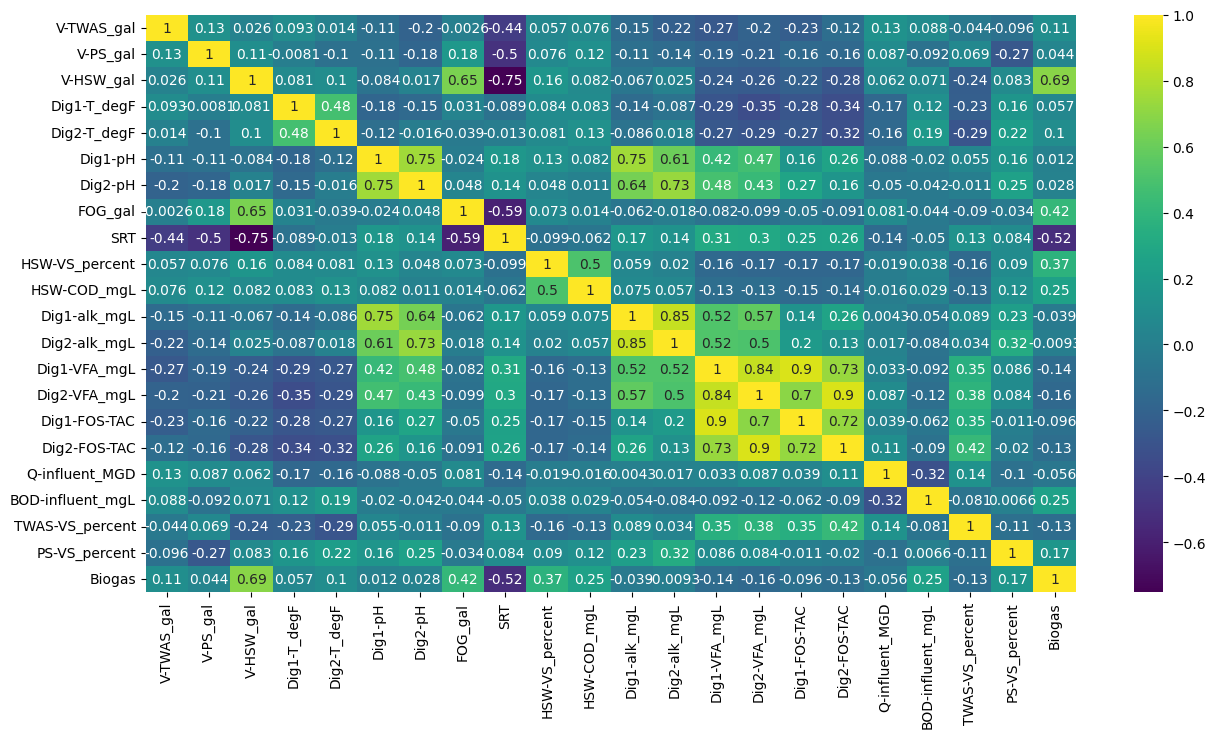

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.pairplot(data)
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap = 'viridis')

In [4]:
df_copy = df.copy()

df_copy.drop(columns=['FOG_gal'], inplace=True)

In [5]:
#Create a digester stability score
# Step 1: Quantile transformation for 'Dig1-T_degF'
x = df_copy['Dig1-T_degF'].values.reshape(-1, 1)
scalerQ = QuantileTransformer(output_distribution = 'normal',random_state = 1)
x_Q = scalerQ.fit_transform(x)

df_copy['Dig1-T_degF'] = x_Q

# Step 2: Calculate mean and standard deviation of 'Dig1-T_degF'
mean_temp = df_copy['Dig1-T_degF'].mean()
std_temp = df_copy['Dig1-T_degF'].std()

# Step 3: Calculate subscores for each feature
df_copy['Subscore1'] = np.where(
    np.abs(df_copy['Dig1-T_degF'] - mean_temp) <= std_temp, 1,
    np.where(np.abs(df_copy['Dig1-T_degF'] - mean_temp) <= 2 * std_temp, 0.5, 0)
)

df_copy['Subscore2'] = np.where(
    (df_copy['Dig1-pH'] >= 6.1) & (df_copy['Dig1-pH'] <= 8.3), 1,
    np.where(
        (df_copy['Dig1-pH'] >= 0.95 * 6.1) & (df_copy['Dig1-pH'] <= 1.05 * 8.3),
        0.75,
        np.where(
            (df_copy['Dig1-pH'] >= 6.1) & (df_copy['Dig1-pH'] <= 8.3), 0.5,
            np.where(
                (df_copy['Dig1-pH'] >= 0.95 * 6.1) & (df_copy['Dig1-pH'] <= 1.05 * 8.3),
                0.25, 0
            )
        )
    )
)

df_copy['Subscore3'] = np.where(
    (df_copy['Dig1-alk_mgL'] >= 2000) & (df_copy['Dig1-alk_mgL'] <= 20000), 1,
    np.where(
        (df_copy['Dig1-alk_mgL'] >= 0.95 * 2000) & (df_copy['Dig1-alk_mgL'] <= 1.05 * 20000),
        0.75,
        np.where(
            (df_copy['Dig1-alk_mgL'] >= 2000) & (df_copy['Dig1-alk_mgL'] <= 20000), 0.5,
            np.where(
                (df_copy['Dig1-alk_mgL'] >= 0.95 * 2000) & (df_copy['Dig1-alk_mgL'] <= 1.05 * 20000),
                0.25, 0
            )
        )
    )
)
# we use mg/L instead of mg COD/L as in Cook et al. and assume mg 1.07 COD/mg VFA
df_copy['Subscore4'] = np.where(
    df_copy['Dig1-VFA_mgL'] < 0.9 * 3037, 1,
    np.where(df_copy['Dig1-VFA_mgL'] < 0.95 * 3037, 0.75,
             np.where(df_copy['Dig1-VFA_mgL'] < 3037, 0.5,
                      np.where(df_copy['Dig1-VFA_mgL'] < 1.05 * 3037, 0.25, 0)
                      )
             )
)

df_copy['Subscore5'] = np.where(df_copy['Dig1-FOS-TAC'] > 0.6, 0,
                               np.where((df_copy['Dig1-FOS-TAC'] >= 0.5) & (df_copy['Dig1-FOS-TAC'] <= 0.6), 0.5,
                                        np.where((df_copy['Dig1-FOS-TAC'] >= 0.4) & (df_copy['Dig1-FOS-TAC'] < 0.5), 0.75,
                                                 np.where(df_copy['Dig1-FOS-TAC'] < 0.4, 1, 0)
                                                 )
                                        )
                               )

# Step 4: Calculate "Dig1-stability" score by averaging subscores
df_copy['Dig1-stability'] = df_copy[['Subscore1', 'Subscore2', 'Subscore3', 'Subscore4', 'Subscore5']].mean(axis=1)

# Step 5: Drop the original columns
df_copy.drop(columns=['Dig1-T_degF', 'Dig1-pH', 'Dig1-alk_mgL', 'Dig1-VFA_mgL', 'Dig1-FOS-TAC'], inplace=True)

df_copy.drop(columns=['Subscore1', 'Subscore2', 'Subscore3', 'Subscore4', 'Subscore5'], inplace=True)

In [6]:
# Step 1: Quantile transformation for 'Dig2-T_degF'
x2 = df_copy['Dig2-T_degF'].values.reshape(-1, 1)
x_Q2 = scalerQ.fit_transform(x2)

df_copy['Dig2-T_degF'] = x_Q2

# Step 2: Calculate mean and standard deviation of 'Dig2-T_degF'
mean_temp = df_copy['Dig2-T_degF'].mean()
std_temp = df_copy['Dig2-T_degF'].std()

# Step 3: Calculate subscores for each feature
df_copy['Subscore1'] = np.where(
    np.abs(df_copy['Dig2-T_degF'] - mean_temp) <= std_temp, 1,
    np.where(np.abs(df_copy['Dig2-T_degF'] - mean_temp) <= 2 * std_temp, 0.5, 0)
)

df_copy['Subscore2'] = np.where(
    (df_copy['Dig2-pH'] >= 6.1) & (df_copy['Dig2-pH'] <= 8.3), 1,
    np.where(
        (df_copy['Dig2-pH'] >= 0.95 * 6.1) & (df_copy['Dig2-pH'] <= 1.05 * 8.3),
        0.75,
        np.where(
            (df_copy['Dig2-pH'] >= 6.1) & (df_copy['Dig2-pH'] <= 8.3), 0.5,
            np.where(
                (df_copy['Dig2-pH'] >= 0.95 * 6.1) & (df_copy['Dig2-pH'] <= 1.05 * 8.3),
                0.25, 0
            )
        )
    )
)

df_copy['Subscore3'] = np.where(
    (df_copy['Dig2-alk_mgL'] >= 2000) & (df_copy['Dig2-alk_mgL'] <= 20000), 1,
    np.where(
        (df_copy['Dig2-alk_mgL'] >= 0.95 * 2000) & (df_copy['Dig2-alk_mgL'] <= 1.05 * 20000),
        0.75,
        np.where(
            (df_copy['Dig2-alk_mgL'] >= 2000) & (df_copy['Dig2-alk_mgL'] <= 20000), 0.5,
            np.where(
                (df_copy['Dig2-alk_mgL'] >= 0.95 * 2000) & (df_copy['Dig2-alk_mgL'] <= 1.05 * 20000),
                0.25, 0
            )
        )
    )
)

df_copy['Subscore4'] = np.where(
    df_copy['Dig2-VFA_mgL'] < 0.9 * 3037, 1,
    np.where(df_copy['Dig2-VFA_mgL'] < 0.95 * 3037, 0.75,
             np.where(df_copy['Dig2-VFA_mgL'] < 3037, 0.5,
                      np.where(df_copy['Dig2-VFA_mgL'] < 1.05 * 3037, 0.25, 0)
                      )
             )
)

df_copy['Subscore5'] = np.where(df_copy['Dig2-FOS-TAC'] > 0.6, 0,
                               np.where((df_copy['Dig2-FOS-TAC'] >= 0.5) & (df_copy['Dig2-FOS-TAC'] <= 0.6), 0.5,
                                        np.where((df_copy['Dig2-FOS-TAC'] >= 0.4) & (df_copy['Dig2-FOS-TAC'] < 0.5), 0.75,
                                                 np.where(df_copy['Dig2-FOS-TAC'] < 0.4, 1, 0)
                                                 )
                                        )
                               )

# Step 4: Calculate "Dig2-stability" score by averaging subscores
df_copy['Dig2-stability'] = df_copy[['Subscore1', 'Subscore2', 'Subscore3', 'Subscore4', 'Subscore5']].mean(axis=1)

# Step 5: Drop the original columns
df_copy.drop(columns=['Dig2-T_degF', 'Dig2-pH', 'Dig2-alk_mgL', 'Dig2-VFA_mgL', 'Dig2-FOS-TAC'], inplace=True)

df_copy.drop(columns=['Subscore1', 'Subscore2', 'Subscore3', 'Subscore4', 'Subscore5'], inplace=True)

In [7]:
df_copy['Dig-stability'] = df_copy[['Dig1-stability', 'Dig2-stability']].mean(axis=1)
df_copy['HSW-VS-load'] = df_copy['V-HSW_gal']*df_copy['HSW-VS_percent']
df_copy['HSW-COD-load'] = df_copy['V-HSW_gal']*df_copy['HSW-COD_mgL']
df_copy['TWAS-VS-load'] = df_copy['V-TWAS_gal']*df_copy['TWAS-VS_percent']
df_copy['PS-VS-load'] = df_copy['V-PS_gal']*df_copy['PS-VS_percent']
df_copy['BOD-load'] = df_copy['Q-influent_MGD']*df_copy['BOD-influent_mgL']
df_copy.drop(columns=['Dig1-stability', 'Dig2-stability','HSW-VS_percent','V-HSW_gal','HSW-COD_mgL','PS-VS_percent','V-PS_gal','TWAS-VS_percent','V-TWAS_gal','Q-influent_MGD','BOD-influent_mgL'], inplace=True)
df_copy.columns

Index(['SRT', 'Biogas', 'Dig-stability', 'HSW-VS-load', 'HSW-COD-load',
       'TWAS-VS-load', 'PS-VS-load', 'BOD-load'],
      dtype='object')

<Axes: >

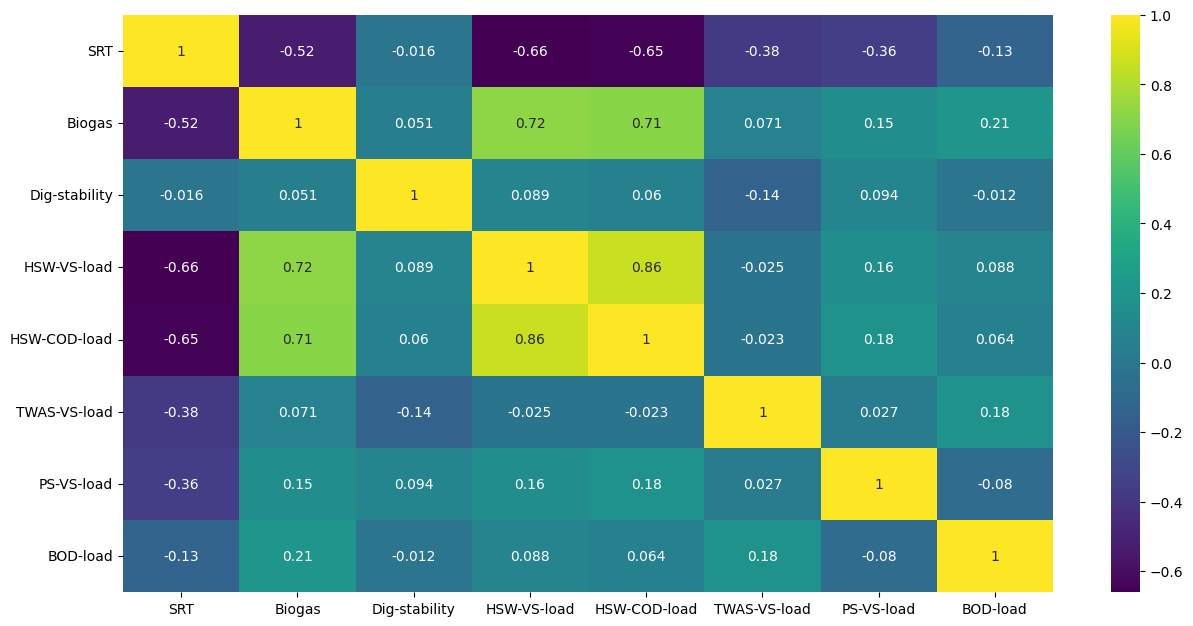

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.pairplot(data)
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.heatmap(df_copy.corr(method='spearman'), annot=True, cmap = 'viridis')

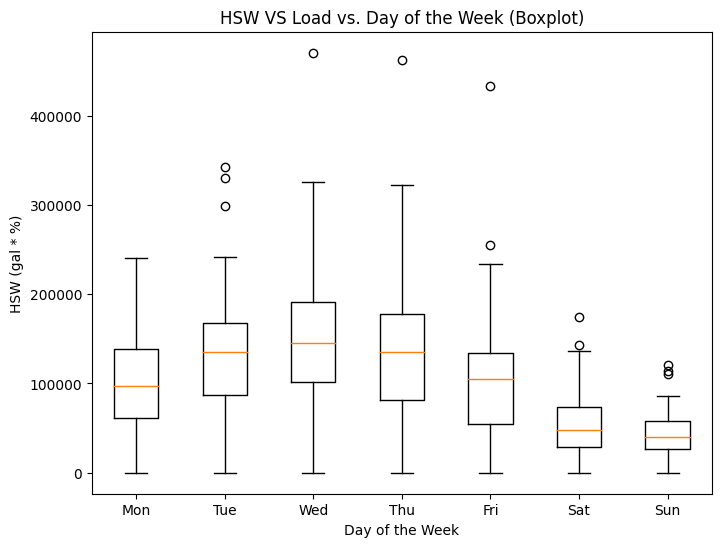

In [9]:
import matplotlib.pyplot as plt
df_copy['HSW-VS-load'] = pd.to_numeric(df_copy['HSW-VS-load'], errors='coerce')  # Force 'HSW-VS-load' column to numeric if necessary

# Specify the desired time period
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2023-03-31')

# Filter the data within the specified time period
filtered_data = df_copy.loc[start_date:end_date, 'HSW-VS-load']

# Group the data by day of the week and keep the index as the day of the week
daily_data = filtered_data.groupby(filtered_data.index.dayofweek, group_keys=False)  # Update groupby with group_keys=False

# Create a new DataFrame with the daily data
daily_df = pd.DataFrame({'HSW-VS-load': daily_data.apply(list)})

# Plot the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(daily_df['HSW-VS-load'].values)
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  # Set x-ticks to represent each day of the week
plt.xlabel('Day of the Week')
plt.ylabel('HSW (gal * %)')
plt.title('HSW VS Load vs. Day of the Week (Boxplot)')
plt.show()

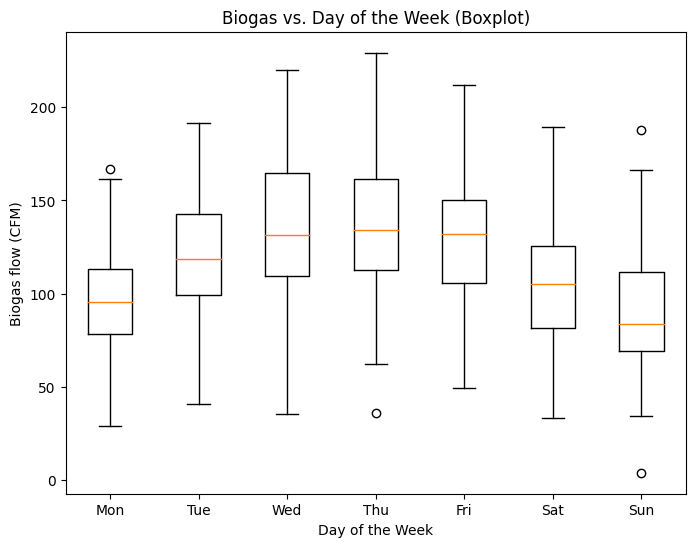

In [10]:
df_copy['Biogas'] = pd.to_numeric(df_copy['Biogas'], errors='coerce')  # Force 'Biogas' column to numeric

# Specify the desired time period
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2023-03-31')

# Filter the data within the specified time period
filtered_data = df_copy.loc[start_date:end_date, 'Biogas']

# Group the data by day of the week and keep the index as the day of the week
daily_data = filtered_data.groupby(filtered_data.index.dayofweek, group_keys=False)  

# Create a new DataFrame with the daily data
daily_df = pd.DataFrame({'Biogas': daily_data.apply(list)})

# Plot the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(daily_df['Biogas'].values)
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  # Set x-ticks to represent each day of the week
plt.xlabel('Day of the Week')
plt.ylabel('Biogas flow (CFM)')
plt.title('Biogas vs. Day of the Week (Boxplot)')
plt.show()

In [11]:
df_copy['DayOfWeek'] = df_copy.index.weekday
df_copy.shape

(1103, 9)

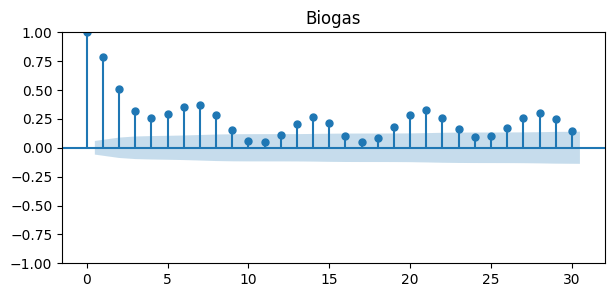

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df_copy['Biogas'], ax=ax, lags=30) # 30 days of lags
plt.title('Biogas')
plt.show()

In [13]:
# 1 day forecast = 1 observation

date_range = pd.date_range(start=df_copy.index.min(), end=df_copy.index.max(), freq='D')

# Reindex the DataFrame with the complete date range
df_copy= df_copy.reindex(date_range).rename_axis('Timestamp')

horizon = int(1) 

# Shift all measurements back a day and BOD to 5 days behind. Then create lagged variables

df_copy = df_copy.shift(1)

data_lagged = df_copy.copy()

data_lagged['BOD-load'] = df_copy['BOD-load'].shift(5)

data_lagged['HSW-COD-load_1'] = df_copy['HSW-COD-load'].shift(1)
data_lagged['HSW-COD-load_2'] = df_copy['HSW-COD-load'].shift(2)
data_lagged['HSW-COD-load_3'] = df_copy['HSW-COD-load'].shift(3)
data_lagged['HSW-COD-load_4'] = df_copy['HSW-COD-load'].shift(4)
data_lagged['HSW-COD-load_5'] = df_copy['HSW-COD-load'].shift(5)
data_lagged['HSW-COD-load_6'] = df_copy['HSW-COD-load'].shift(6)
data_lagged['HSW-VS-load_1'] = df_copy['HSW-VS-load'].shift(1)
data_lagged['HSW-VS-load_2'] = df_copy['HSW-VS-load'].shift(2)
data_lagged['HSW-VS-load_3'] = df_copy['HSW-VS-load'].shift(3)
data_lagged['HSW-VS-load_4'] = df_copy['HSW-VS-load'].shift(4)
data_lagged['HSW-VS-load_5'] = df_copy['HSW-VS-load'].shift(5)
data_lagged['HSW-VS-load_6'] = df_copy['HSW-VS-load'].shift(6)
data_lagged['PS-VS-load_1'] = df_copy['PS-VS-load'].shift(1)
data_lagged['PS-VS-load_2'] = df_copy['PS-VS-load'].shift(2)
data_lagged['PS-VS-load_3'] = df_copy['PS-VS-load'].shift(3)
data_lagged['PS-VS-load_4'] = df_copy['PS-VS-load'].shift(4)
data_lagged['PS-VS-load_5'] = df_copy['PS-VS-load'].shift(5)
data_lagged['PS-VS-load_6'] = df_copy['PS-VS-load'].shift(6)
data_lagged['TWAS-VS-load_1'] = df_copy['TWAS-VS-load'].shift(1)
data_lagged['TWAS-VS-load_2'] = df_copy['TWAS-VS-load'].shift(2)
data_lagged['TWAS-VS-load_3'] = df_copy['TWAS-VS-load'].shift(3)
data_lagged['TWAS-VS-load_4'] = df_copy['TWAS-VS-load'].shift(4)
data_lagged['TWAS-VS-load_5'] = df_copy['TWAS-VS-load'].shift(5)
data_lagged['TWAS-VS-load_6'] = df_copy['TWAS-VS-load'].shift(6)
data_lagged['Biogas_1'] = df_copy['Biogas'].shift(1)
data_lagged['Biogas_2'] = df_copy['Biogas'].shift(2)
data_lagged['Biogas_3'] = df_copy['Biogas'].shift(3)
data_lagged['Biogas_4'] = df_copy['Biogas'].shift(4)
data_lagged['Biogas_5'] = df_copy['Biogas'].shift(5)
data_lagged['Biogas_6'] = df_copy['Biogas'].shift(6)

data_lagged.dropna(inplace=True)
data_lagged.shape

(1090, 39)

In [14]:
data_lagged.to_csv("LABS-for-combined.csv", index=True)